In [1]:
from sys import path
path.append('/home/rui/blacksid/mew-p')
DATA_PATH = '/home/rui/blacksid/data/dockfuture'
import numpy as np
import pytz
from datetime import datetime
import cProfile
import matplotlib.pyplot as plt
from mewp.simulate.wrapper import TrendAlgoWrapper
from mewp.simulate.runner import SingleRunner
import pandas
from mewp.util.clock import Clock
from mewp.util.candle import Candle
from mewp.util.candle import CandleCreator
from mewp.util.candle import CandleAnalysis

In [2]:
class ATR(object):
    ## Constructor
    # @param alpha for ema
    def __init__(self, alpha):
        self.alpha = alpha
        
        # computed
        self.mean = 0
        
    ## add a new observation, and refresh
    def add(self, observe):
        if (self.mean == 0):
            self.mean = observe
        else:
            self.mean = self.mean + self.alpha * (observe - self.mean)



## Algo

In [3]:
## 趋势突破
class TestAlgo(TrendAlgoWrapper):

    # called when algo param is set
    def param_updated(self):
        # make sure parent updates its param
        super(TestAlgo, self).param_updated()
        self.last_pnl = 0
        self.atr = ATR(0.1)
        self.pre_high = []
        self.pre_volume = []
        self.pre_low = []
        self.pre_close = []
        self.history_high = None
        self.history_low = None
    # @param date Trading day
    # @param period Period of next tick
    # @param old_period The period that is ending
    def on_periodend(self, date, period, old_period):
        # example print info on period end
        timezone = pytz.timezone('Asia/Shanghai') 
        print 'Periodend {} period {:15s} -> {:15s}'.format(
                datetime.fromtimestamp(Clock.timestamp/1000, timezone),
                old_period, period)
        
    def on_daystart(self, date, info):
        print 'Daystart  {}'.format(date)
        self.start_time = Clock.timestamp
        # new candle for day, and new analyze
        if  hasattr(self, 'candle'):
            del self.candle
        self.candle = CandleCreator(self.param['min'], self.item.get_unit_perhand())
        
    def on_dayend(self, date, info): 
        # clear position if any
        #self.account.clear()
        # print pnl
        pnl = self.account.get_pnl()
        print 'Dayend    {} PNL {:10.1f} Day {:10.1f}'.format(date, pnl, pnl - self.last_pnl)
        self.last_pnl = pnl
        # update candle, and day candle
        self.end_time = Clock.timestamp
    
    def update_lists(self, cur_candle):
        self.pre_high.append(cur_candle.high)
        self.pre_low.append(cur_candle.low)
        self.pre_volume.append(cur_candle.trade_vol)
        self.pre_close.append(cur_candle.close_price)
        if len(self.pre_high) > self.param['window']:
            self.pre_high.pop(0)
            self.pre_low.pop(0)
            self.pre_volume.pop(0)
        if len(self.pre_close) > self.param['f2']:
            self.pre_close.pop(0)

    def buy_filter(self):
        if np.mean(self.pre_close[-self.param['f1']:]) > np.mean(self.pre_close[-self.param['f2']:]):
            return True
        else:
            return False
    
    def sell_filter(self):
        if np.mean(self.pre_close[-self.param['f1']:]) < np.mean(self.pre_close[-self.param['f2']:]):
            return True
        else:
            return False
    
    def on_tick(self, multiple, contract, info):
        new_candle = self.candle.on_tick(info, tickclass=True)
        if info.ask_1_price ==0 or info.bid_1_price == 0:
            return
        pos = self.position()
        if new_candle:
            cur_candle = self.candle.candles[-1]
            if len(self.pre_close) > 0:
                    TR = max(self.pre_close[-1], cur_candle.high) - min(self.pre_close[-1], cur_candle.low)
                    self.atr.add(TR)
            if len(self.pre_close) < self.param['f2']:
                self.update_lists(cur_candle)
                print len(self.pre_close)
                return
            elif cur_candle.close_price > np.max(self.pre_high) and\
                cur_candle.trade_vol > np.max(self.pre_volume) and self.buy_filter():
                    qty = np.min([self.param['cap']-pos,1]) if pos >= 0 else (-pos + 1)
                    order = self.long(qty = qty)
                    self.history_high = info.ask_1_price
                    self.history_low = None
            elif cur_candle.close_price < np.min(self.pre_low) and\
                cur_candle.trade_vol > np.max(self.pre_volume) and self.sell_filter():
                    qty = np.min([self.param['cap']+pos,1]) if pos <= 0 else (pos + 1)
                    order = self.short(qty=qty)
                    self.history_high = None
                    self.history_low = info.bid_1_price
            self.update_lists(cur_candle)
        pos = self.position()
        #ATR stoploss
        if pos > 0:
            assert(self.history_high!=None)
            if info.bid_1_price > self.history_high:
                self.history_high = info.bid_1_price
            diff = self.history_high - info.bid_1_price
            assert(diff>=-1e-6)
            if diff > self.param['ATR_stoploss'] * self.atr.mean:
                print 'Clear'
                self.account.clear()
                self.history_high = None
            
        if pos < 0:
            assert(self.history_low!=None)
            if info.ask_1_price < self.history_low:
                self.history_low = info.ask_1_price
            diff = info.ask_1_price - self.history_low
            assert(diff>=-1e-6)
            if diff > self.param['ATR_stoploss'] * self.atr.mean:
                print 'Clear'
                self.account.clear()
                self.history_low = None

## Runner

In [4]:
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-01-01','2015-10-31').tolist()]


In [4]:
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-01-01','2015-10-31').tolist()]
algo = { 'class': TestAlgo }
algo['param'] = {'item': 'cu', 'min': 60, 'window': 20,'cap': 1, 'f1': 50, 'f2': 100,
                 'ATR_stoploss': 3}
settings = { 'date': dates, 'algo': algo, 'tickset': 'top',
             'path': DATA_PATH }

In [5]:
runner = SingleRunner(settings)
runner.run()
#Profile.run('runner.run()', sort='cumtime')

Reading configs ...
Reading data ...
Skipping date 2015-01-01 ...
Skipping date 2015-01-02 ...
Skipping date 2015-01-03 ...
Skipping date 2015-01-04 ...
Reading item cu1503 starting 2015-01-05 ...
Skipping date 2015-01-10 ...
Skipping date 2015-01-11 ...
Skipping date 2015-01-17 ...
Skipping date 2015-01-18 ...
Reading item cu1504 starting 2015-01-22 ...
Skipping date 2015-01-24 ...
Skipping date 2015-01-25 ...
Skipping date 2015-01-31 ...
Skipping date 2015-02-01 ...
Skipping date 2015-02-07 ...
Skipping date 2015-02-08 ...
Skipping date 2015-02-14 ...
Skipping date 2015-02-15 ...
Reading item cu1505 starting 2015-02-17 ...
Skipping date 2015-02-18 ...
Skipping date 2015-02-19 ...
Skipping date 2015-02-20 ...
Skipping date 2015-02-21 ...
Skipping date 2015-02-22 ...
Skipping date 2015-02-23 ...
Skipping date 2015-02-24 ...
Skipping date 2015-02-28 ...
Skipping date 2015-03-01 ...
Skipping date 2015-03-07 ...
Skipping date 2015-03-08 ...
Skipping date 2015-03-14 ...
Skipping date 2015-

In [5]:
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-07-01','2015-12-31').tolist()]
algo = { 'class': TestAlgo }
algo['param'] = {'item': 'm', 'min': 60, 'window': 20,'cap': 1, 'f1': 50, 'f2': 100,
                 'ATR_stoploss': 3}
settings = { 'date': dates, 'algo': algo, 'tickset': 'top',
             'path': DATA_PATH }
runner = SingleRunner(settings)
runner.run()
#Profile.run('runner.run()', sort='cumtime')

Reading configs ...
Reading data ...
Reading item m1509 starting 2015-07-01 ...
Skipping date 2015-07-04 ...
Skipping date 2015-07-05 ...
Skipping date 2015-07-11 ...
Skipping date 2015-07-12 ...
Skipping date 2015-07-18 ...
Skipping date 2015-07-19 ...
Reading item m1601 starting 2015-07-22 ...
Skipping date 2015-07-25 ...
Skipping date 2015-07-26 ...
Skipping date 2015-08-01 ...
Skipping date 2015-08-02 ...
Skipping date 2015-08-08 ...
Skipping date 2015-08-09 ...
Skipping date 2015-08-15 ...
Skipping date 2015-08-16 ...
Skipping date 2015-08-22 ...
Skipping date 2015-08-23 ...
Skipping date 2015-08-29 ...
Skipping date 2015-08-30 ...
Skipping date 2015-09-03 ...
Skipping date 2015-09-04 ...
Skipping date 2015-09-05 ...
Skipping date 2015-09-06 ...
Skipping date 2015-09-12 ...
Skipping date 2015-09-13 ...
Skipping date 2015-09-19 ...
Skipping date 2015-09-20 ...
Skipping date 2015-09-26 ...
Skipping date 2015-09-27 ...
Skipping date 2015-10-01 ...
Skipping date 2015-10-02 ...
Skippin

<IPython.core.display.Javascript object>


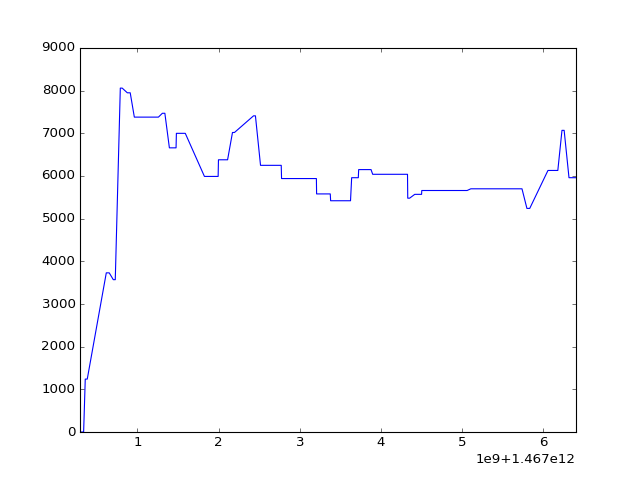

In [11]:
from mewp.simulate.report import Report
%matplotlib notebook
report = Report(runner)

In [ ]:
algo['param'] = {'item': 'cu', 'min': 5, 'window': 20,'cap': 1, 'stoploss':0.03,
                 'candles': candle_object_per_day, 'days': candle_per_day}
dates = [str(x).split(' ')[0] for x in pandas.date_range('2015-07-01','2016-09-10').tolist()]
settings = { 'date': dates, 'algo': algo, 'tickset': 'top',
             'path': '/home/greedy/blacksid/data/dockfuture' }
runner = SingleRunner(settings)
runner.run()

Reading configs ...
Reading data ...
Reading item cu1509 starting 2015-07-01 ...
Skipping date 2015-07-04 ...
Skipping date 2015-07-05 ...
Skipping date 2015-07-11 ...
Skipping date 2015-07-12 ...
Skipping date 2015-07-18 ...
Skipping date 2015-07-19 ...
Reading item cu1510 starting 2015-07-24 ...
Skipping date 2015-07-25 ...
Skipping date 2015-07-26 ...
Skipping date 2015-08-01 ...
Skipping date 2015-08-02 ...
Skipping date 2015-08-08 ...
Skipping date 2015-08-09 ...
Skipping date 2015-08-15 ...
Skipping date 2015-08-16 ...
Skipping date 2015-08-22 ...
Skipping date 2015-08-23 ...
Reading item cu1511 starting 2015-08-26 ...
Skipping date 2015-08-29 ...
Skipping date 2015-08-30 ...
Skipping date 2015-09-03 ...
Skipping date 2015-09-04 ...
Skipping date 2015-09-05 ...
Skipping date 2015-09-06 ...
Skipping date 2015-09-12 ...
Skipping date 2015-09-13 ...
Skipping date 2015-09-19 ...
Skipping date 2015-09-20 ...
Reading item cu1512 starting 2015-09-25 ...
Skipping date 2015-09-26 ...
Skip

In [6]:
from mewp.simulate.report import Report
%matplotlib notebook
report = Report(runner)
# history = report.get_realized_pnl()
# history.pnl.plot()

In [18]:
dd = report.get_daily_pnl().daily_pnl
d_pnl = np.asarray(dd)

In [26]:
import pickle 
with open('./m_20150101_20150630.p','wb') as f:
    pickle.dump(dd,f)

In [21]:
pandas.to_datetime(dd.index)

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-12', '2015-01-14', '2015-01-15',
               '2015-01-19', '2015-01-20',
               ...
               '2015-06-16', '2015-06-17', '2015-06-18', '2015-06-19',
               '2015-06-23', '2015-06-24', '2015-06-25', '2015-06-26',
               '2015-06-29', '2015-06-30'],
              dtype='datetime64[ns]', length=115, freq=None)

<IPython.core.display.Javascript object>


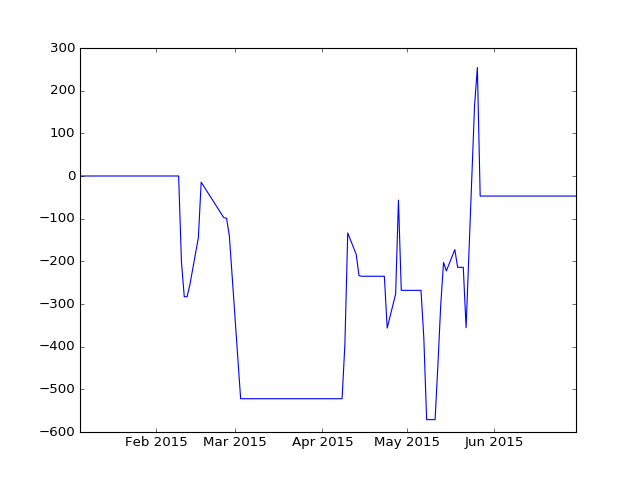

In [23]:
plt.plot(pandas.to_datetime(dd.index), np.cumsum(d_pnl))

In [21]:
algo['param'] = {'item': 'au', 'min': 5, 'window': 20,'cap': 5, 'stoploss':0.02,
                 'candles': candle_object_per_day, 'days': candle_per_day}
runner = SingleRunner(settings)
runner.run()

Reading configs ...
Reading data ...
Reading item au1612 starting 2016-07-01 ...
Skipping date 2016-07-02 ...
Skipping date 2016-07-03 ...
Skipping date 2016-07-09 ...
Skipping date 2016-07-10 ...
Skipping date 2016-07-16 ...
Skipping date 2016-07-17 ...
Skipping date 2016-07-23 ...
Skipping date 2016-07-24 ...
item is au: 922242 entries from 21 days
Preparing data ...
Preparation complete ...
Preparing algo ...
Test start ...
Daystart  2016-07-01
Periodend 2016-06-30 21:00:00+08:00 period Period.rest     -> Period.night   
Periodend 2016-07-01 02:29:59+08:00 period Period.night    -> Period.first   
Periodend 2016-07-01 10:14:58+08:00 period Period.first    -> Period.second  
Periodend 2016-07-01 11:29:59+08:00 period Period.second   -> Period.third   
Periodend 2016-07-01 14:59:59+08:00 period Period.third    -> Period.rest    
Dayend    2016-07-01 PNL      820.0 Day      820.0
Daystart  2016-07-04
Periodend 2016-07-01 21:00:00+08:00 period Period.rest     -> Period.night   
Perioden

In [5]:
history = runner.account.history.to_dataframe()
history[-5:]

,timestamp,cash,pnl,float_pnl,mid_pnl,min_money,deposit,trading_day,ni1609
1469775598000,1469775598000,-56760.0,23540.0,-340.0,23555.0,6149.0,6424.0,20160729,1
1469775598500,1469775598500,-56760.0,23540.0,-340.0,23555.0,6149.0,6424.0,20160729,1
1469775599000,1469775599000,-56760.0,23550.0,-330.0,23560.0,6146.4,6426.4,20160729,1
1469775599500,1469775599500,-56760.0,23570.0,-310.0,23575.0,6131.4,6426.4,20160729,1
1469775599500,1469775599500,23564.0,23564.0,0.0,23564.0,-284.0,0.0,20160729,0


In [6]:
orders = runner.account.orders.to_dataframe()
print len(orders)
#orders

254


<IPython.core.display.Javascript object>


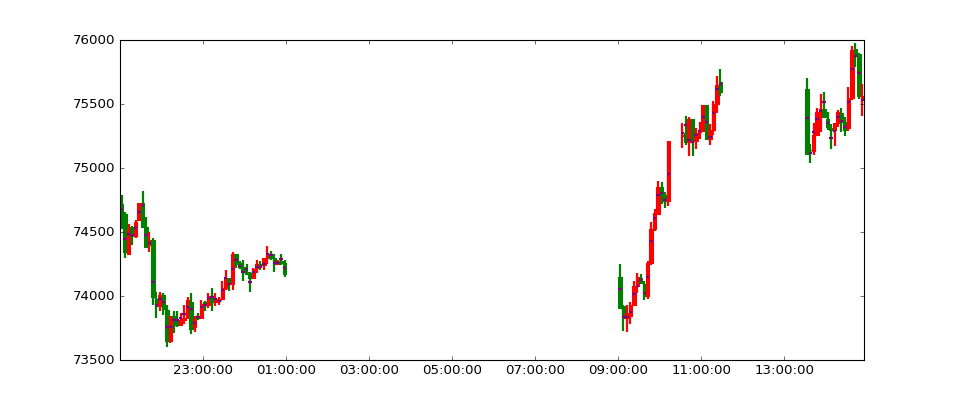

In [7]:
%matplotlib notebook
candle_object_per_day[0].plot_all(plot_vwap=True)

<IPython.core.display.Javascript object>


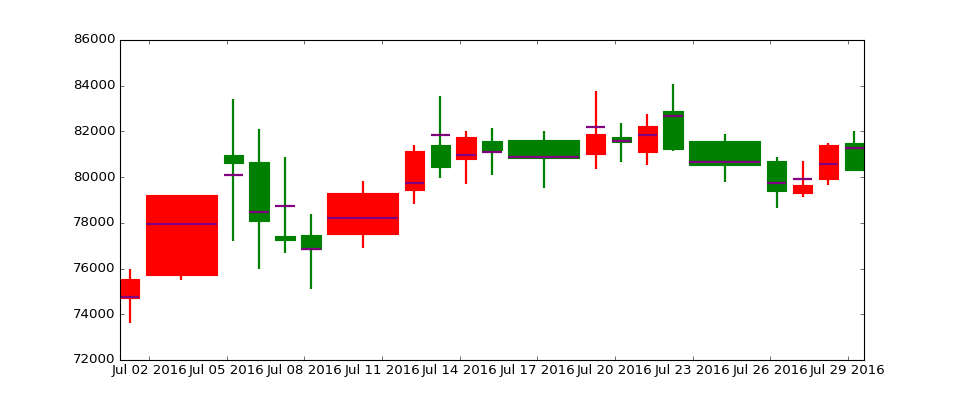

In [8]:
CandleCreator.plot_candles(candle_per_day, plot_vwap=True)

In [7]:
from mewp.simulate.report import Report
report = Report(runner)
report.print_report(to_file=False)

--- Simulation Report ---
              return  max_draw_down max_draw_down_start max_draw_down_end  \
2016-07-01 -0.002224         1472.0            11:25:39          14:39:12   
2016-07-04  0.068367          600.0            23:47:04          23:50:50   
2016-07-05 -0.050091         4732.0            09:36:22          14:06:17   
2016-07-06 -0.010202         4652.0            23:11:42          09:48:18   
2016-07-07  0.016415          560.0            14:02:04          14:03:08   
2016-07-08 -0.034063         7520.0            10:37:19          14:55:36   
2016-07-11  0.011217         1012.0            21:00:00          09:50:42   
2016-07-12 -0.002611         2252.0            21:00:00          14:41:49   
2016-07-13 -0.020065         4906.0            00:16:27          13:56:43   
2016-07-14 -0.025940         4744.0            21:00:00          13:42:20   
2016-07-15 -0.027898         6922.0            21:00:00          21:30:07   
2016-07-18 -0.010589         9200.0            21:

,return,max_draw_down,max_draw_down_start,max_draw_down_end,order_count,daily_pnl,daily_pnl_night,daily_pnl_first,daily_pnl_second,daily_pnl_third,min_money,final_pnl,final_return,sharpie_ratio,tot_days,win_ratio
2016-07-01,-0.002224,1472.0,11:25:39,14:39:12,3.0,-184.0,0.0,344.0,280.0,-888.0,6748.6,NaN,NaN,NaN,NaN,NaN
2016-07-04,0.068367,600.0,23:47:04,23:50:50,3.0,5656.0,4208.0,1160.0,20.0,-12.0,12355.2,NaN,NaN,NaN,NaN,NaN
2016-07-05,-0.050091,4732.0,09:36:22,14:06:17,3.0,-4144.0,0.0,-1652.0,140.0,-2632.0,17040.8,NaN,NaN,NaN,NaN,NaN
2016-07-06,-0.010202,4652.0,23:11:42,09:48:18,3.0,-844.0,1448.0,-2012.0,0.0,0.0,13504.4,NaN,NaN,NaN,NaN,NaN
2016-07-07,0.016415,560.0,14:02:04,14:03:08,2.0,1358.0,0.0,0.0,0.0,1358.0,6733.8,NaN,NaN,NaN,NaN,NaN
2016-07-08,-0.034063,7520.0,10:37:19,14:55:36,5.0,-2818.0,-742.0,940.0,208.0,-2744.0,28298.8,NaN,NaN,NaN,NaN,NaN
2016-07-11,0.011217,1012.0,21:00:00,09:50:42,2.0,928.0,0.0,504.0,830.0,-546.0,6408.4,NaN,NaN,NaN,NaN,NaN
2016-07-12,-0.002611,2252.0,21:00:00,14:41:49,4.0,-216.0,-386.0,-660.0,260.0,490.0,15220.8,NaN,NaN,NaN,NaN,NaN
2016-07-13,-0.020065,4906.0,00:16:27,13:56:43,6.0,-1660.0,-788.0,-710.0,-862.0,690.0,16878.0,NaN,NaN,NaN,NaN,NaN
2016-07-14,-0.025940,4744.0,21:00:00,13:42:20,4.0,-2146.0,0.0,-1522.0,-678.0,34.0,15871.2,NaN,NaN,NaN,NaN,NaN
